In [1]:
import os
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fmap.core.compositions import generateCompositions,createComposition
from fmap.ref_data import periodic_table,materials
from fmap.core.pycalphad_run import pycalphad_eq,pycalphad_scheil
from fmap.core.GenerateEqScript import createEqScript
from fmap.core.ReadEqResult import getEqdata
from fmap.core.GenerateScheilScript import createScheilScript
from fmap.core.ReadScheilResult import getScheilSolidPhase
from fmap.plot.FeasibilityMap import plotMaps

Materials info

Input

In [8]:
# Create Compositions
comps = ['Cu','Ag', 'Al']

ngridpts = 1  # number of points along each dimension of the composition grid

TemperatureRange = (600, 2000,10) #(lower limit, upper limit, temperature step)

indep_comps = [comps[1], comps[2]]  # choose them automatically
for i in comps:
    if i in periodic_table:
        materials[i] = {i:1}
    elif i not in materials.keys():
        materials[i] = {'SS304L':{'Ni':0.09611451943, 'Cr':0.1993865031, 'Fe':0.7044989775}}# the composition of this element/alloys(in weight fractions)
maxNumSim = 250  # maximum number of simulations in each TCM file
# Equilibrium simulation settings
pressure = 101325
database = '/Users/sunhui/Desktop/new-charge/Feasibility/Ag-Al-Cu.TDB' # 'C-Cr-Cu-Fe-Mo-Nb-Ni-03-08.tdb' #'C-Cr-Cu-Fe-Mo-Nb-Ni-10-05.tdb'#'Cr-Fe-Ni-Ti-V_04-05.tdb' # <userDatabase>.TDB or TCFE8
eleAmountType = 'massFraction' # Candidates: massFraction massPercent moleFraction molePercent
output_Eq = f'{TemperatureRange[0]}-{TemperatureRange[1]}-{TemperatureRange[2]}-{comps[0]}-{comps[1]}-{comps[2]}-Eq'

In [9]:
from datetime import datetime

current_dateTime = datetime.now()
if '.tdb' in database or '.TDB' in database:
    database_name = database.split('/')
    path = f'./Simulation/{datetime.now().strftime("%m-%d-%Y")}-{comps[0]}-{comps[1]}-{comps[2]}-database-{database_name[-1][:-4]}'
else:
    path = f'./Simulation/{datetime.now().strftime("%m-%d-%Y")}-{comps[0]}-{comps[1]}-{comps[2]}-database-{database}'
isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path)
    print("The new directory is created!")

In [46]:
compositions_list = generateCompositions(indep_comps,ngridpts)
Compositions, numPoint, comp, numSimultion = createComposition(indep_comps,comps,compositions_list,materials,path)
settings = [TemperatureRange,numPoint,numSimultion,comp,comps,indep_comps,database,pressure,eleAmountType]
np.save(f'{path}/setting.npy',settings)

['Ag', 'Al'] ['Cu', 'Ag', 'Al'] [{'Ag': 0.0, 'Al': 0.0}, {'Ag': 0.0, 'Al': 1.0}, {'Ag': 1.0, 'Al': 0.0}] {'SS304L(C)': {'Ni': 0.0960978153081775, 'Cr': 0.199351850905262, 'Fe': 0.704376539865259, 'C': 0.000173793921302023}, 'SS316': {'Ni': 0.129412983, 'Cr': 0.176001656, 'Fe': 0.668702764, 'Mo': 0.025882597}, 'IN625': {'Ni': 0.664001619, 'Cr': 0.212529096, 'Fe': 0.001012043, 'Nb': 0.034409473, 'Mo': 0.088047768}, 'NiCr': {'Ni': 0.8, 'Cr': 0.2}, 'Monel400': {'Fe': 0.020298386, 'Ni': 0.639399168, 'Cu': 0.340302446}, 'Cu': {'Cu': 1}, 'Ag': {'Ag': 1}, 'Al': {'Al': 1}} ./Simulation/06-20-2023-Cu-Ag-Al-database-Ag-Al-Cu
Equilibrium simulation #: 3
Point #: 3
Element #: 3
relatedElement #: ['AL', 'CU', 'AG']


In [48]:
print(TemperatureRange,numPoint,numSimultion,comp,comps,indep_comps,database,pressure,eleAmountType)

(600, 2000, 10) 3 3 ['AL', 'CU', 'AG'] ['Cu', 'Ag', 'Al'] ['Ag', 'Al'] /Users/sunhui/Desktop/new-charge/Feasibility/Ag-Al-Cu.TDB 101325 massFraction


In [2]:
from importlib_resources import files
path = str(files('fmap').joinpath('tests/testsCaseFiles'))
createEqScript(path)

100%|██████████| 3/3 [00:00<00:00, 25890.77it/s]


[('CU', 'AG'), ('CU', 'AL'), ('AG', 'AL')]


100%|██████████| 3/3 [00:00<00:00, 18780.47it/s]

n [{'CU': [0], 'AG': [0], 'AL': [1], 'alloy_Cu': [0], 'alloy_Ag': [0], 'alloy_Al': [1], 'Index': [1]}, {'CU': [0], 'AG': [1], 'AL': [0], 'alloy_Cu': [0], 'alloy_Ag': [1], 'alloy_Al': [0], 'Index': [2]}, {'CU': [1], 'AG': [0], 'AL': [0], 'alloy_Cu': [1], 'alloy_Ag': [0], 'alloy_Al': [0], 'Index': [0]}]
1th simulation in 0th file
1th simulation in 0th file
1th simulation in 0th file


In [30]:
from fmap.core.GenerateEqScript import getSettings,sortCompositions
import os
database = None
settings = getSettings(path) #[TRange, numFile, comp1, comp2, comps, folder_Eq, folder_Scheil, composition_data, Compositions, comp, pressure, database]
path = os.path.abspath(path)
Compositions = settings[8]
comp = settings[9]
if database == None:
    database = settings[11]
output_Eq = settings[5]
TemperatureRange = settings[0]
pressure = settings[10]
a = []
output = sortCompositions(Compositions)
index_compositionList = 0
for Compositions in output:
    compositions = {}
    relatedEles = []
    for ele in comp:
        compositions[ele] = Compositions[ele]
        if Compositions[ele][0] != 0:
            relatedEles.append(ele)
    fileName = ''
    for ele in relatedEles:
        fileName += f'{ele}-'
    Indexs = Compositions['Index']
    a.append(output_Eq + '/' + f'{index_compositionList}_{fileName[:-1]}_0.TCM')
    index_compositionList += 1

100%|██████████| 3/3 [00:00<00:00, 31536.12it/s]


[('CU', 'AG'), ('CU', 'AL'), ('AG', 'AL')]


100%|██████████| 3/3 [00:00<00:00, 29959.31it/s]


In [31]:
a

['/Users/sunhui/Desktop/new-charge/feasibility_map/fmap/tests/testsCaseFiles/Thermo-calc/Equilibrium Simulation/0_AL_0.TCM',
 '/Users/sunhui/Desktop/new-charge/feasibility_map/fmap/tests/testsCaseFiles/Thermo-calc/Equilibrium Simulation/1_AG_0.TCM',
 '/Users/sunhui/Desktop/new-charge/feasibility_map/fmap/tests/testsCaseFiles/Thermo-calc/Equilibrium Simulation/2_CU_0.TCM']

Running with pycalphad

In [10]:
pycalphad_eq(path)

{X_AG: 5.891033483737375e-06, X_AL: 2.3551034016150884e-05} (1/3)
{X_AG: 2.501423738743817e-06, X_AL: 0.9999932524620155} (2/3)
{X_AG: 0.9999430495515953, X_AL: 3.997628572726799e-05} (3/3)


In [2]:
pycalphad_scheil('/Users/sunhui/Desktop/new-charge/feasibility_map/Simulation/06-19-2023-Cu-Ag-Al-database-Ag-Al-Cu',2000)

cannot find liquid phase in eq results, start with back up temperature
cannot find liquid phase in eq results, start with back up temperature
cannot find liquid phase in eq results, start with back up temperature
cannot find liquid phase in eq results, start with back up temperature
cannot find liquid phase in eq results, start with back up temperature
cannot find liquid phase in eq results, start with back up temperature
cannot find liquid phase in eq results, start with back up temperature
cannot find liquid phase in eq results, start with back up temperature
cannot find liquid phase in eq results, start with back up temperature
cannot find liquid phase in eq results, start with back up temperature
cannot find liquid phase in eq results, start with back up temperature
cannot find liquid phase in eq results, start with back up temperature
cannot find liquid phase in eq results, start with back up temperature
cannot find liquid phase in eq results, start with back up temperature
cannot

/Users/sunhui/opt/anaconda3/envs/feasibility1/lib/python3.9/site-packages/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)
/Users/sunhui/opt/anaconda3/envs/feasibility1/lib/python3.9/site-packages/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.constituents.
  warnings.warn(msg, FutureWarning)
/Users/sunhui/opt/anaconda3/envs/feasibility1/lib/python3.9/site-packages/pycalphad/core/utils.py:157: FutureWarning: generate_dof is deprecated and will be removed in a future version of pycalphad. The correct way to determine the degrees of freedom of a particular 'active' phase is to use Model.consti

UnboundLocalError: local variable 'current_fraction_solid' referenced before assignment

Running with Thermo_Calc

In [2]:
path = './Simulation/06-19-2023-Cu-Ag-Al-database-Ag-Al-Cu'
print(path)

./Simulation/06-19-2023-Cu-Ag-Al-database-Ag-Al-Cu


In [12]:
createEqScript(path)

The new directory for Eq is created!
The new directory for Scheil is created!


100%|██████████| 3/3 [00:00<00:00, 19753.39it/s]


[('CU', 'AG'), ('AL', 'CU'), ('AL', 'AG')]


100%|██████████| 3/3 [00:00<00:00, 21147.75it/s]


1th simulation in 0th file


100%|██████████| 1/1 [00:00<00:00, 656.59it/s]


1th simulation in 1th file


100%|██████████| 1/1 [00:00<00:00, 4877.10it/s]


1th simulation in 2th file


100%|██████████| 1/1 [00:00<00:00, 8473.34it/s]

###################################################
All the equilibrium simulation scripts are created!


In [13]:
createScheilScript(path,2000)

[(600, 2000, 10), 3, 'Ag', 'Al', ['Cu', 'Ag', 'Al'], '/Users/sunhui/Desktop/new-charge/feasibility_map/Simulation/06-20-2023-Cu-Ag-Al-database-Ag-Al-Cu/Thermo-calc/Equilibrium Simulation', '/Users/sunhui/Desktop/new-charge/feasibility_map/Simulation/06-20-2023-Cu-Ag-Al-database-Ag-Al-Cu/Thermo-calc/Scheil Simulation',    Cu  Ag  Al
0   1   0   0
1   0   0   1
2   0   1   0, {'AL': array([0, 1, 0]), 'CU': array([1, 0, 0]), 'AG': array([0, 0, 1]), 'alloy_Cu': array([1, 0, 0]), 'alloy_Ag': array([0, 0, 1]), 'alloy_Al': array([0, 1, 0]), 'Index': array([0, 1, 2])}, ['AL', 'CU', 'AG'], 101325, '/Users/sunhui/Desktop/new-charge/Feasibility/Ag-Al-Cu.TDB']
##################################################
No equilibrium result found! Will use the backUpStartTemp as liquidus temperature!
##################Finish input Scheil parameters#######################
###############################################################################
Start to read liquidus temperature for each point from eq

100%|██████████| 3/3 [00:00<00:00, 9931.26it/s]


[('CU', 'AG'), ('AL', 'CU'), ('AL', 'AG')]


100%|██████████| 3/3 [00:00<00:00, 21326.97it/s]


In [6]:
getEqdata(path)
getScheilSolidPhase(path)

###################################################################
####################### Reading Eq Result #########################


100%|██████████| 3/3 [00:00<00:00, 11.24it/s]


####################### Reading Eq Result Done ####################
0 files failed. FailList:
[]
#####################################################
#############start reading Scheil Result#############


100%|██████████| 3/3 [00:00<00:00, 619.33it/s]


####################################################################
Getting final Scheil result...


100%|██████████| 3/3 [00:00<00:00, 43539.49it/s]

##########################end reading Scheil#############################
Read Scheil Temperature vs Liquid fraction (mole):
Failed Index List: []
0 Files Failed to Read


In [2]:
path = '/Users/sunhui/Desktop/new-charge/feasibility_map/tasks/06-20-2023-Cu-Ag-Al-database-Ag-Al-Cu'

In [41]:
coord,EqMaxBadPhaseAmount,ScheilMaxBadPhaseAmount,EqThrshold,ScheilThreshold,xComp,yComp,dynamicTRange,comps,dynamicRatio = ([(0, 0), (0, 1), (1, 0)],[0, 0, 1],[0.9999982643265233, 0.0, 0.0],0.1,0.05,'Ag','Al',True,['Cu', 'Ag', 'Al'],0.6666666666666666)

In [47]:
engine = 'thermo_calc'
path = ''

In [48]:
if engine.lower() == 'pycalphad':
    path = path + '/Pycalphad'
elif engine.lower() == 'thermo-calc' or engine.lower() == 'thermo_calc' or engine.lower() == 'thermocalc':
    path = path + '/Thermo-calc'

In [49]:
print(path)

/Thermo-calc


####################################################################
Plotting Scheil-Eq Feasibility Map
Plotting Ag-Al-Cu done!
####################################################################
Plotting Scheil-Eq Temperature Map
Plotting Scheil-Eq Temperature Map done!
####################################################################
Plotting Scheil Phase Heat Map
Plotting Scheil Phase Heat Map done!
##############################################################
0 samples do not have enough data point.
0 samples have no result.
##############################################################
output [6.0, 0.0, 0.0] [-0.0938680875903521, 0.1, 0.09999999999995622] [2.8036046755815147, 13.047120908158863, 10.150332105288118] [0, 0.0, 0.0] [0, 0.0, 0.0]
input [(0, 0), (0, 1), (1, 0)] Ag Al [6.0, 0.0, 0.0] [-0.0938680875903521, 0.1, 0.09999999999995622] [2.8036046755815147, 13.047120908158863, 10.150332105288118] [0, 0.0, 0.0] [0, 0.0, 0.0]
###############################################

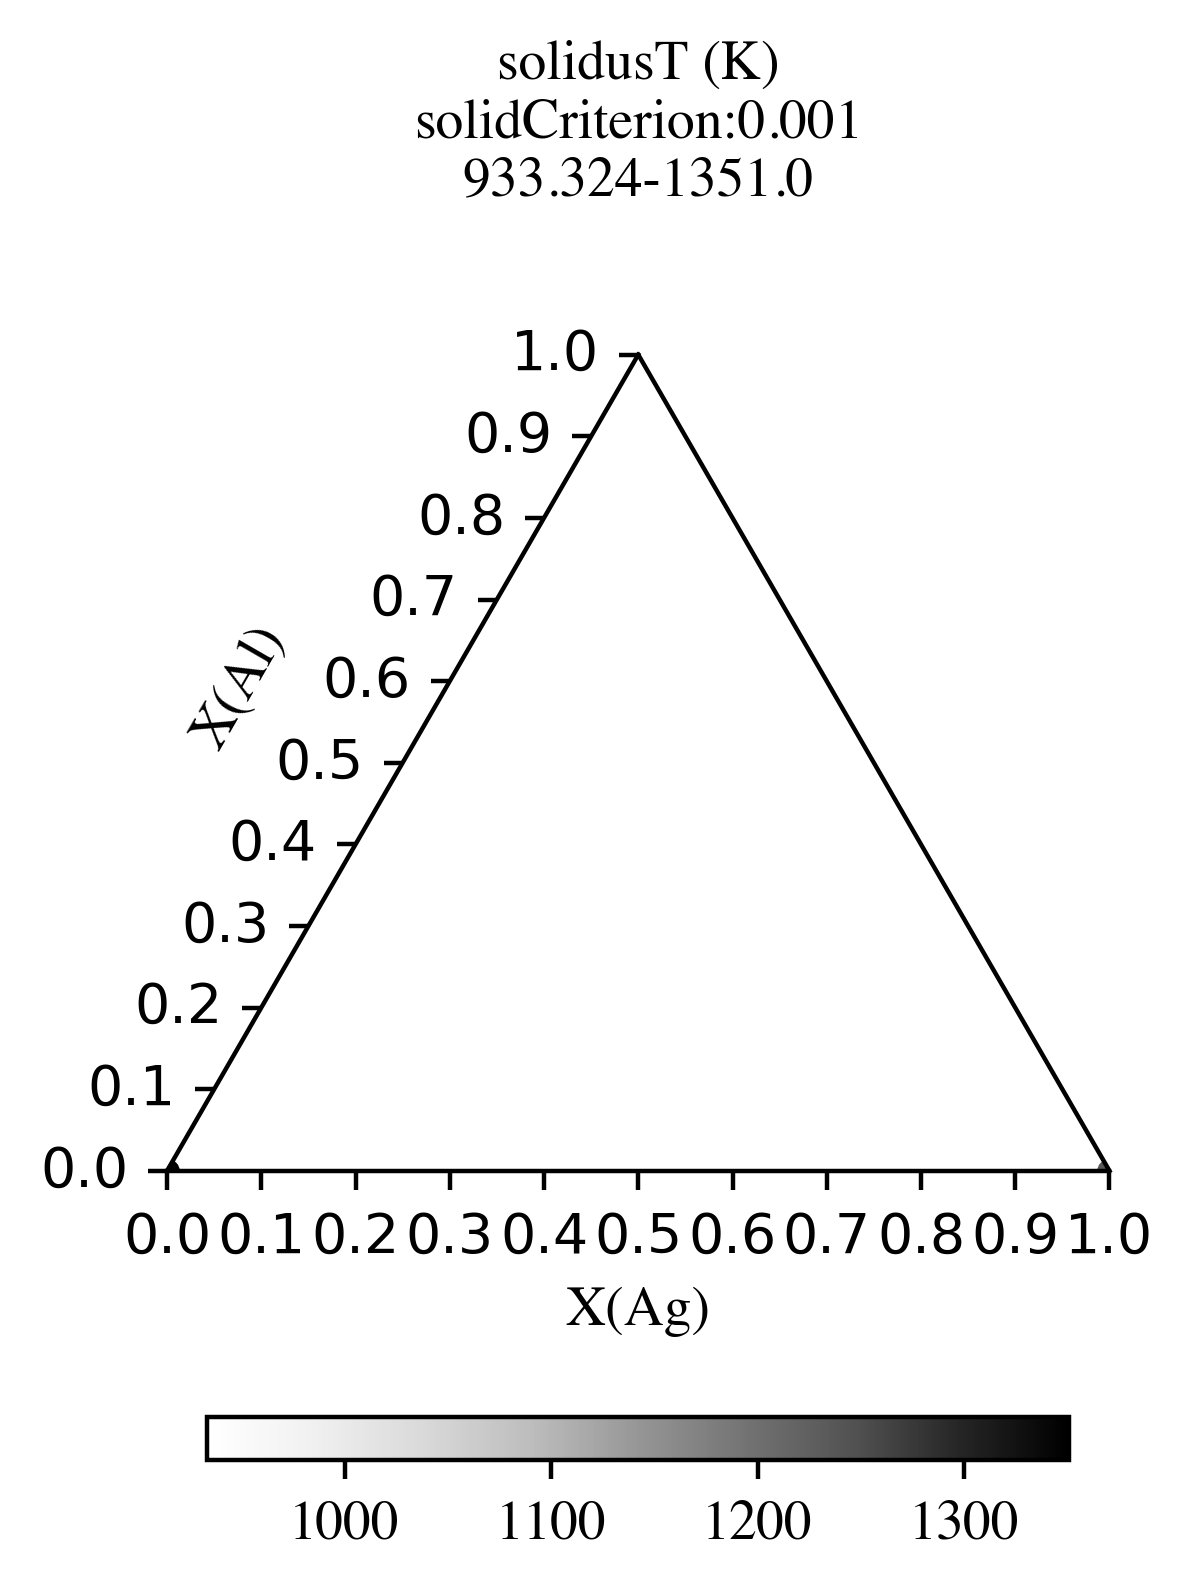

In [3]:
plotMaps(path,'pycalphad',dynamicTRange = True, dynamicRatio = 2/3, ScheilThreshold = 0.05, EqThrshold = 0.1, allowPhase = ['FCC','BCC','HCP','LIQUID'],solidCriterion = 0.001)

Running with PyCalphad

1. restructure it like pysipfenn (finished)

- fmap
    - core
    - data:
        - Ag-Al-Cu.TDB
- notebooks:
    - notebook1
    - ...
2. read test (one function left)
    - path didn't work (package not installed)
    - ResourceWarning: Enable tracemalloc to get the object allocation traceback
    - delete the files after tests
3. pyproject.toml (do with first) (finished) reduce
4. MANIFEST,in (to do)
5. doc.
6. bug in scheil (one of the depend pyckage)
 

In [ ]:
with resources.files('fmap').joinpath('data/Ag-Al-Cu.TDB') as database:
    fmap.something(database)

In [ ]:
fmap.something(database='mylocation/nice.tdb')